## MNE Classification of 2 Class

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

In [2]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from mne import concatenate_epochs
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize

#### Step 1: READ Dataset 

- read all subjects

In [3]:
DataFolder = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'

In [4]:
subjects = [1, 2, 3, 4, 5, 6]

# Label 6 classes
label_map = {
    'forearm supination': 0,
    'forearm pronation': 1,
    'shoulder adduction': 2,
    'shoulder abduction': 3,
    'elbow extension': 4,
    'elbow flexion': 5
}

# Helper สำหรับเรียง Run
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

# เตรียมเก็บข้อมูล
EpochList = []
y_all = []

# Load ทุก Subject และ Run
for s in subjects:
    for file_name in sorted(os.listdir(DataFolder), key=extract_run_num):
        if file_name.startswith(f"S{s}R") and file_name.endswith(".set"):
            path = os.path.join(DataFolder, file_name)
            print(f"Reading {file_name}...")

            try:
                # Load .set
                epochs = mne.io.read_epochs_eeglab(path, verbose='ERROR')

                #  สร้าง mapping ชื่อ event เดิม (เช่น S1R1_elbow flexion)
                id_to_name = {v: k for k, v in epochs.event_id.items()}

                #  รีแมพทุก event ใหม่ให้ match กับ label_map
                new_events = []
                selected_labels = []

                for i, (onset, _, eid) in enumerate(epochs.events):
                    event_name = id_to_name[eid].split('_')[-1]
                    if event_name in label_map:
                        new_eid = label_map[event_name]
                        new_events.append([onset, 0, new_eid])
                        selected_labels.append(new_eid)

                if new_events:
                    # 📎 สร้าง Epochs ใหม่ด้วย event ที่รีแมพแล้ว
                    new_events = np.array(new_events)
                    epochs.events = new_events
                    epochs.event_id = label_map.copy()

                    # เฉพาะ epoch ที่เราใช้จริง
                    EpochList.append(epochs)
                    y_all.extend(selected_labels)

            except Exception as e:
                print(f"❌ Failed to load {file_name}: {e}")

# รวมเป็นก้อนเดียวแบบปลอดภัย
combined_epochs = concatenate_epochs(EpochList)
X_all = combined_epochs.get_data()
y_all = np.array(y_all)

# สรุป
print("\n รวมข้อมูลเสร็จแล้ว:")
print(" X shape:", X_all.shape)         # (n_epochs, n_channels, n_times)
print(" y shape:", y_all.shape)         # (n_epochs,)
print(" Label counts (0–5):", np.bincount(y_all))


Reading S1R1.set...
Reading S1R2.set...
Reading S1R3.set...
Reading S1R4.set...
Reading S1R5.set...
Reading S1R6.set...
Reading S1R7.set...
Reading S1R8.set...
Reading S1R9.set...
Reading S1R10.set...
Reading S2R1.set...
Reading S2R2.set...
Reading S2R3.set...
Reading S2R4.set...
Reading S2R5.set...
Reading S2R6.set...
Reading S2R7.set...
Reading S2R8.set...
Reading S2R9.set...
Reading S2R10.set...
Reading S3R1.set...
Reading S3R2.set...
Reading S3R3.set...
Reading S3R4.set...
Reading S3R5.set...
Reading S3R6.set...
Reading S3R7.set...
Reading S3R8.set...
Reading S3R9.set...
Reading S3R10.set...
Reading S4R1.set...
Reading S4R2.set...
Reading S4R3.set...
Reading S4R4.set...
Reading S4R5.set...
Reading S4R6.set...
Reading S4R7.set...
Reading S4R8.set...
Reading S4R9.set...
Reading S4R10.set...
Reading S5R1.set...
Reading S5R2.set...
Reading S5R3.set...
Reading S5R4.set...
Reading S5R5.set...
Reading S5R6.set...
Reading S5R7.set...
Reading S5R8.set...
Reading S5R9.set...
Reading S5R10.se

#### Test Combined epochs

In [5]:
combined_epochs

<EpochsArray | 10800 events (all good), -1 – 1.998 s (baseline off), ~1.93 GiB, data loaded,
 'forearm supination': 1800
 'forearm pronation': 1800
 'shoulder adduction': 1800
 'shoulder abduction': 1800
 'elbow extension': 1800
 'elbow flexion': 1800>

#### Step 2: Bandpass filter

In [6]:
#copy old dataset
combined_copy = combined_epochs.copy()

#Apply bandpass
filtered_epochs = combined_copy.filter(l_freq=8.0, h_freq=30.0)

figfilter = filtered_epochs.plot(n_epochs=3, events=True, event_id=True)

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.4s
[Parallel(n_job

MemoryError: std::bad_alloc

#### Check BandPass

In [ ]:
print("High-pass:", filtered_epochs.info['highpass'])
print("Low-pass :", filtered_epochs.info['lowpass'])

High-pass: 8.0
Low-pass : 30.0


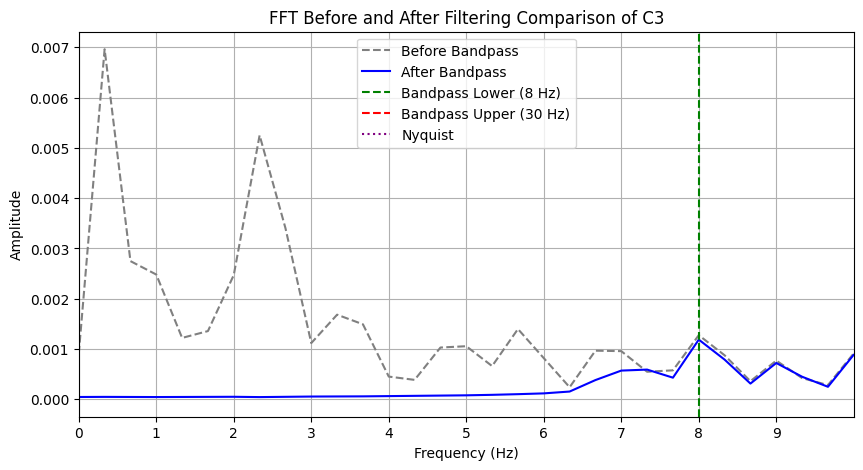

In [ ]:
#Plot fft
channel_nam = 'C3'
channel_id = combined_epochs.ch_names.index(channel_nam)  # ก่อน filter
fis = combined_epochs.info['sfreq']

# สัญญาณก่อน filter
signal_before = combined_epochs.get_data()[0, channel_id, :]
# สัญญาณหลัง filter
signal_after = filtered_epochs.get_data()[0, channel_id, :]

# FFT
nu = len(signal_after)
freqs = np.fft.rfftfreq(nu, 1/fis)
fft_before = np.abs(np.fft.rfft(signal_before))
fft_after = np.abs(np.fft.rfft(signal_after))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_before, label="Before Bandpass", color='gray', linestyle='--')
plt.plot(freqs, fft_after, label="After Bandpass", color='blue')
plt.axvline(8, color='green', linestyle='--', label='Bandpass Lower (8 Hz)')
plt.axvline(30, color='red', linestyle='--', label='Bandpass Upper (30 Hz)')
plt.axvline(fis/2, color='purple', linestyle=':', label='Nyquist')

plt.title(f"FFT Before and After Filtering Comparison of {channel_nam}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
# plt.xlim(0, fs / 2)
# plt.ylim(0, 0.0015)  
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 1))  # ticks each 1 Hz
# plt.ylim(0,0.005)
# plt.yticks(np.arange(0, 0.005, 0.001))  # ticks each 1 Hz
plt.show()


In [ ]:
#Plot power Before 
combined_epochs.compute_psd(fmax=60).plot(picks=combined_epochs.ch_names)
plt.show()

NameError: name 'combined_epochs' is not defined

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


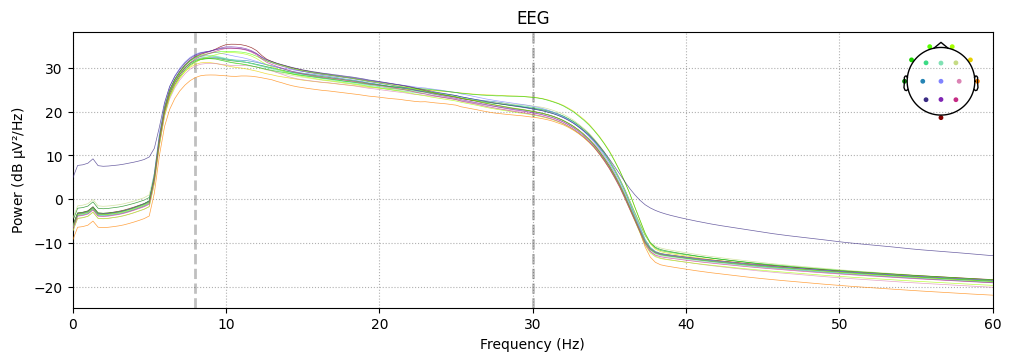

In [ ]:
#Plot power After
filtered_epochs.compute_psd(fmax=60).plot(picks=filtered_epochs.ch_names)
plt.show()

#### Step 3: DownSampling

In [ ]:
downsampled_epochs = filtered_epochs.copy().resample(128)#128 100
downsampled_epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, Fp1, P3, Pz, P4, Fp2, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 16
 projs: []
 sfreq: 128.0 Hz
>

#### Check DownSampling

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


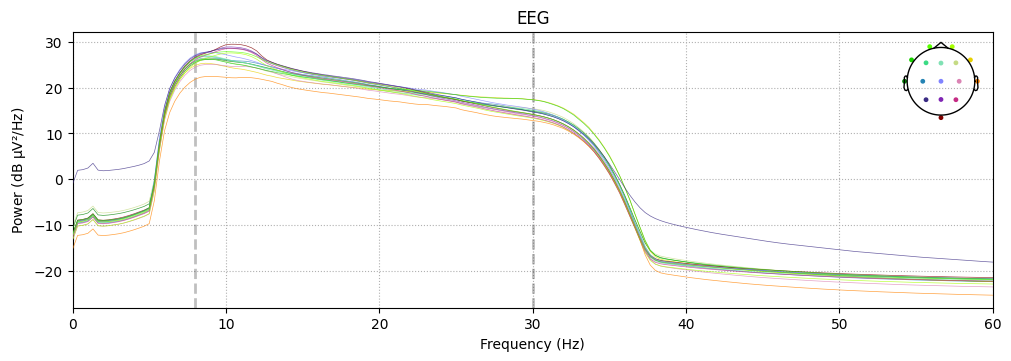

In [ ]:
#Plot power 
downsampled_epochs.compute_psd(fmax=60).plot(picks=downsampled_epochs.ch_names)
plt.show()

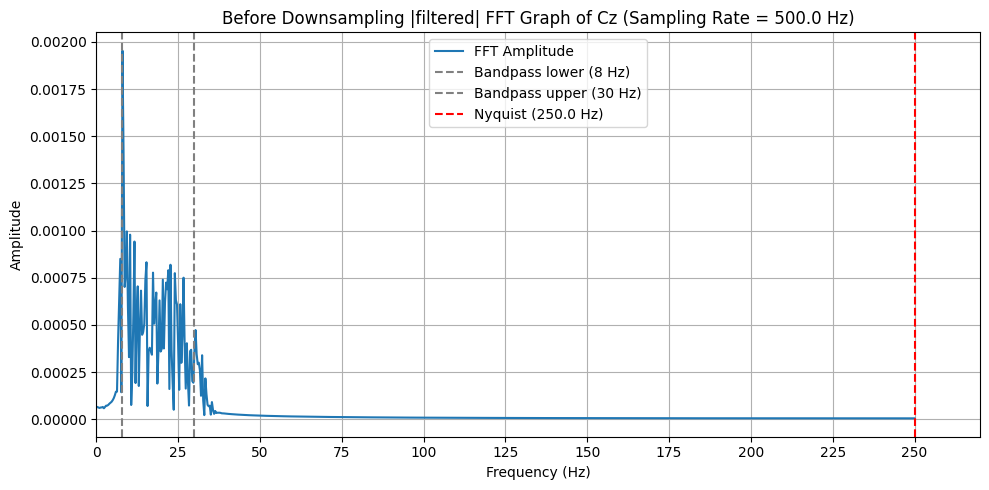

In [ ]:
#FFT method Before

# Pick channel
chan_namee = 'Cz'
chan_indexx = filtered_epochs.ch_names.index(chan_namee)

# Get signal
ss = filtered_epochs.get_data()[0, chan_indexx, :]
fss = filtered_epochs.info['sfreq']

# FFT
nn = len(ss)
freqss = np.fft.rfftfreq(nn, 1/fss)
fft_valss = np.abs(np.fft.rfft(ss))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqss, fft_valss, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fss/2, color='red', linestyle='--', label=f'Nyquist ({fss/2:.1f} Hz)')
plt.title(f"Before Downsampling |filtered| FFT Graph of {chan_namee} (Sampling Rate = {fss} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0, 270)
plt.xticks(np.arange(0, 270, 25))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

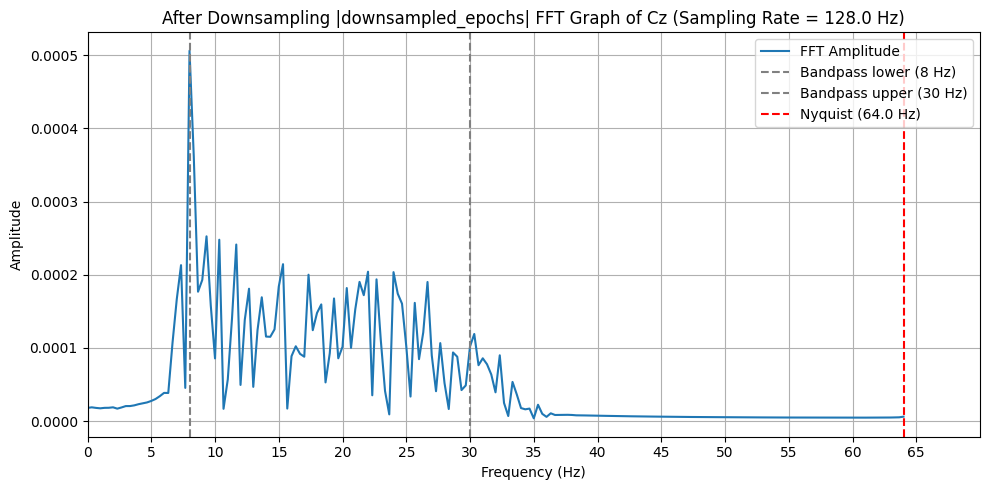

In [ ]:
#FFT method after

# Pick channel
chan_name = 'Cz'
chan_index = downsampled_epochs.ch_names.index(chan_name)

# Get signal
s = downsampled_epochs.get_data()[0, chan_index, :]
fs = downsampled_epochs.info['sfreq']

# FFT
n = len(s)
freqs = np.fft.rfftfreq(n, 1/fs)
fft_vals = np.abs(np.fft.rfft(s))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_vals, label='FFT Amplitude')
plt.axvline(8, color='gray', linestyle='--', label='Bandpass lower (8 Hz)')
plt.axvline(30, color='gray', linestyle='--', label='Bandpass upper (30 Hz)')
plt.axvline(fs/2, color='red', linestyle='--', label=f'Nyquist ({fs/2:.1f} Hz)')
plt.title(f"After Downsampling |downsampled_epochs| FFT Graph of {chan_name} (Sampling Rate = {fs} Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.xlim(0, fs / 2)
plt.xlim(0,70)
plt.xticks(np.arange(0, 70, 5))  # ticks each 1 Hz
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Step 4: ICA

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 51.0s.


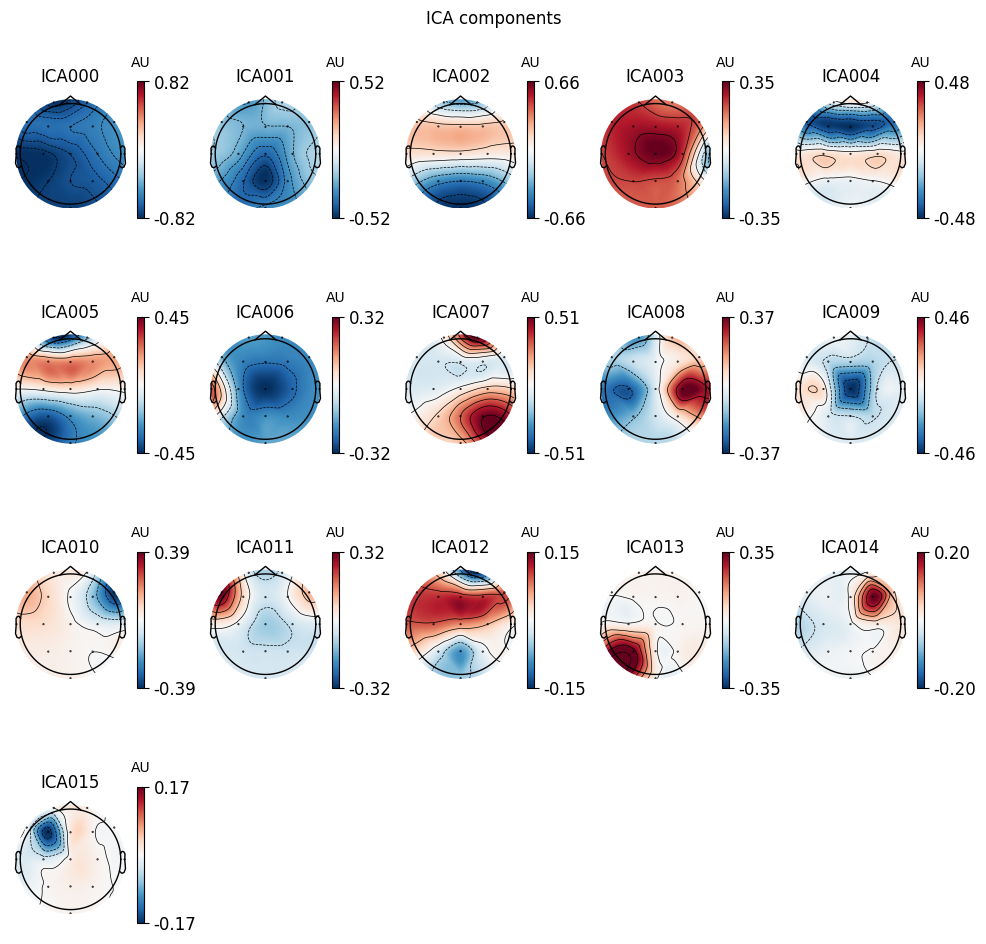

C:\Users\HP\AppData\Local\Temp\ipykernel_27320\673093396.py:14: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_27320\673093396.py:14: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(ICAprocess, ica, method='iclabel')
C:\Users\HP\AppData\Local\Temp\ipykernel_27320\673093396.py:14: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the e

Component 0: heart beat
Component 1: heart beat
Component 2: brain
Component 3: brain
Component 4: brain
Component 5: brain
Component 6: brain
Component 7: brain
Component 8: brain
Component 9: brain
Component 10: brain
Component 11: brain
Component 12: brain
Component 13: brain
Component 14: brain
Component 15: brain


In [ ]:
#make a goddam copy
ICAprocess = downsampled_epochs.copy()

#ICA Object
ica = mne.preprocessing.ICA(n_components=16, random_state=42, max_iter='auto')

#Fit ICA
ica.fit(ICAprocess)

#PlotComponents: topomap and layout
fig = ica.plot_components(colorbar=True)

#Label components using MNE ICALabel
labels = label_components(ICAprocess, ica, method='iclabel')
for i, label in enumerate(labels['labels']):
    print(f"Component {i}: {label}")

In [ ]:
#Delete components except brain
exclude_idx = [i for i, label in enumerate(labels['labels']) if label in ['eye', 'muscle', 'heart beat']]
CleanAlready = ica.apply(ICAprocess, exclude = exclude_idx)

Applying ICA to Epochs instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


#### Check ICA

In [ ]:
print("Excluded ICA components:", exclude_idx)

Excluded ICA components: [0, 1]


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\python3_11_2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


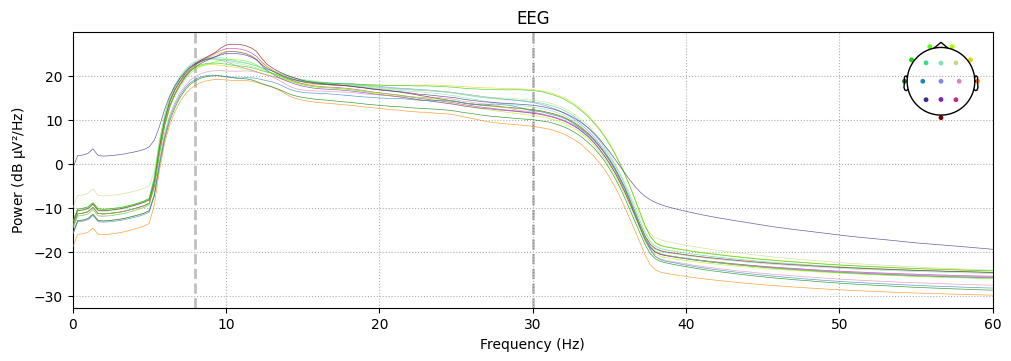

In [ ]:
#Plot power 
CleanAlready.compute_psd(fmax=60).plot(picks=CleanAlready.ch_names)
plt.show()

#### Step 5: Epoching and Baseline correction

In [ ]:
#Chek if the dataset is done it
print(CleanAlready.baseline)

None


In [ ]:
#Epoching
target_classes = [
    
    'elbow flexion',
    'elbow extension'
]

#Select Class from dataset
Selected_epochs = CleanAlready[target_classes]
Selected_epochs

<EpochsArray | 3600 events (all good), -1 – 1.992 s (baseline off), ~168.8 MiB, data loaded,
 'elbow extension': 1800
 'elbow flexion': 1800>

In [ ]:
#epoch range
print(Selected_epochs.tmin, Selected_epochs.tmax)

-1.0 1.9921875


In [ ]:
#Baseline Correction

#backup
Selectedtuna = Selected_epochs.copy()

Selectedtuna.apply_baseline(baseline=(-0.5, 0))
print("Baseline applied:", Selectedtuna.baseline)
print("Epoch shape:", Selectedtuna.get_data().shape)  # (n_epochs, n_channels, n_times)

Applying baseline correction (mode: mean)
Baseline applied: (-0.5, 0.0)
Epoch shape: (3600, 16, 384)


#### Check Baseline

In [ ]:
#Check time per epoch
n_times = Selectedtuna.get_data().shape[2]  # จำนวน sample ต่อ 1 epoch
sfreq = Selectedtuna.info['sfreq']          # sampling rate (Hz)

# คำนวณ duration
duration_sec = n_times / sfreq
print(f"Duration per epoch: {duration_sec:.3f} seconds")


Duration per epoch: 3.000 seconds


In [ ]:
# ก่อน
mean_before = np.mean(Selected_epochs.get_data(), axis=2)  # (n_epochs, n_channels)
mean_after = np.mean(Selectedtuna.get_data(), axis=2)

# ดูค่าเฉลี่ยรวมทุก channel ทุก epoch
print(" Mean ก่อน baseline correction:", np.mean(mean_before))
print(" Mean หลัง baseline correction:", np.mean(mean_after))


 Mean ก่อน baseline correction: 6.649241167205094e-10
 Mean หลัง baseline correction: -2.051740355386124e-09


#### Step 4: Feature Extraction
    - Common Spatial Pattern (CSP)

In [ ]:
# Extract data and labels
X = Selectedtuna.get_data()
y = Selectedtuna.events[:, -1]
# Encode label from [1,2,3,4,5,6] → [0,1,2,3,4,5] which model would like to read like this
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded , test_size=0.2, random_state=42)

In [ ]:
X.shape

(3600, 16, 384)

In [ ]:
# 1. Fit CSP using ONLY training data
csp = CSP(n_components=16, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)

# 2. Then transform test set with fitted CSP
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 16 dim * 1e+10  max singular value)
    Estimated rank (data): 14
    data: rank 14 computed from 16 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 16 -> 14
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


In [ ]:
figx = csp.plot_patterns(info=Selectedtuna.info)

ValueError: Times should be between 0.0 and 13.0.

#### Step 5: Classification

#### LDA (Linear Discriminant Analysis)


[TEST] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.53      0.53      0.53       372
  elbow flexion       0.50      0.50      0.50       348

       accuracy                           0.51       720
      macro avg       0.51      0.51      0.51       720
   weighted avg       0.51      0.51      0.51       720

[TEST] Confusion Matrix


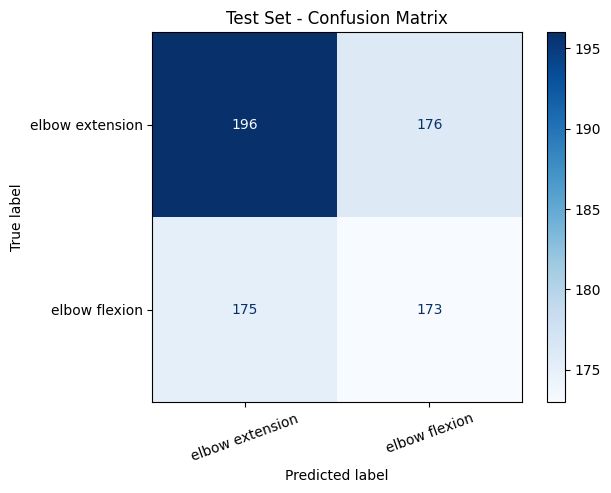


[TRAIN] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.55      0.53      0.54      1428
  elbow flexion       0.55      0.57      0.56      1452

       accuracy                           0.55      2880
      macro avg       0.55      0.55      0.55      2880
   weighted avg       0.55      0.55      0.55      2880

[TRAIN] Confusion Matrix


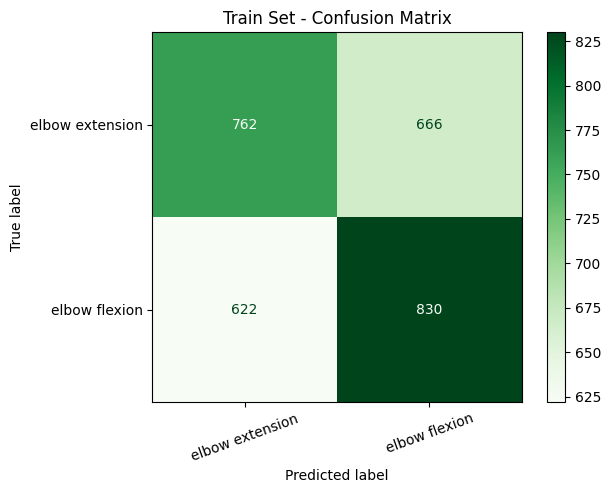

In [ ]:
X = X_train_csp
y = y_train
X_test = X_test_csp

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best LDA
lda_pipeline = Pipeline([('clf', LinearDiscriminantAnalysis())])
lda_params = {'clf__solver': ['lsqr', 'eigen'], 'clf__shrinkage': ['auto', None]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lda_grid = GridSearchCV(lda_pipeline, lda_params, cv=cv, scoring='accuracy', n_jobs=-1)
lda_grid.fit(X_train_csp, y_train)

# Final model
best_lda = lda_grid.best_estimator_
best_lda.fit(X_train_csp, y_train)

# ========= TEST SET RESULTS ========= #
y_test_pred = best_lda.predict(X_test_csp)
y_test_proba = best_lda.predict_proba(X_test_csp)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(cm_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels=class_n)
disp.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

# ========= TRAIN SET RESULTS ========= #
y_train_pred = best_lda.predict(X_train_csp)
y_train_proba = best_lda.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
disp.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


#### SVM (Support Vector Machine)


[TEST] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.76      0.78      0.77       372
  elbow flexion       0.76      0.73      0.74       348

       accuracy                           0.76       720
      macro avg       0.76      0.76      0.76       720
   weighted avg       0.76      0.76      0.76       720

[TEST] Confusion Matrix


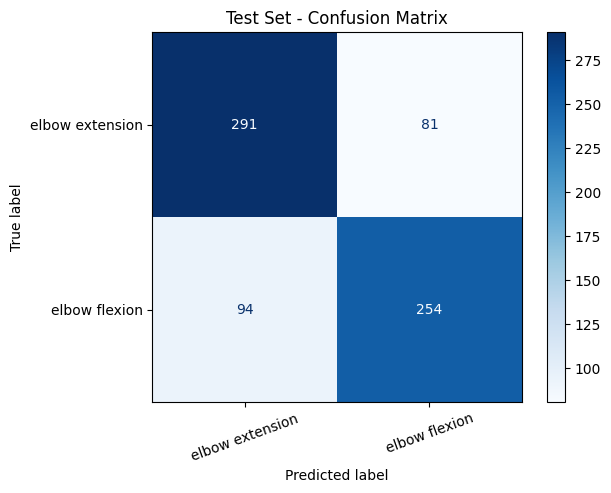


[TRAIN] Classification Report
                 precision    recall  f1-score   support

elbow extension       0.81      0.83      0.82      1428
  elbow flexion       0.83      0.81      0.82      1452

       accuracy                           0.82      2880
      macro avg       0.82      0.82      0.82      2880
   weighted avg       0.82      0.82      0.82      2880

[TRAIN] Confusion Matrix


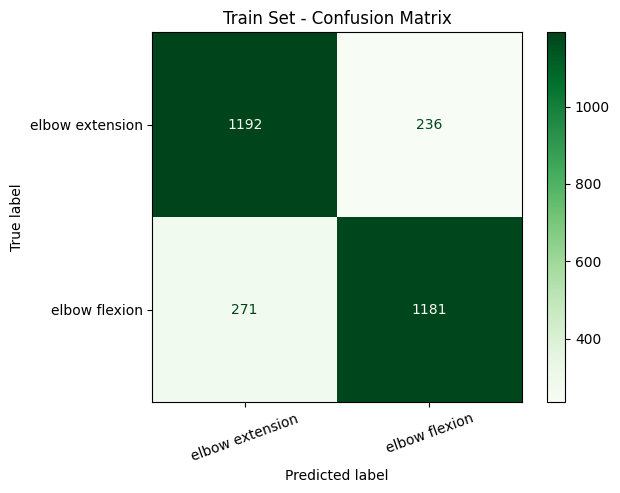

In [ ]:
X = X_train_csp
y = y_train
X_test_final = X_test_csp
n_classes = len(np.unique(y))

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selectedtuna.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best SVM
svm_pipeline = Pipeline([('clf', SVC(probability=True))])  # ต้องเปิด probability=True เพื่อใช้ ROC AUC
svm_params = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']  # เฉพาะ RBF ใช้ gamma
}
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_csp, y_train)

# Final model
best_svm = svm_grid.best_estimator_
best_svm.fit(X_train_csp, y_train)

# ========= TEST SET =========
y_test_pred = best_svm.predict(X_test_final)
y_test_proba = best_svm.predict_proba(X_test_final)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
dis = ConfusionMatrixDisplay(cm_test,display_labels=class_n)
dis.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


# ========= TRAIN SET =========
y_train_pred = best_svm.predict(X_train_csp)
y_train_proba = best_svm.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
dis2 = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
dis2.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

#### KNN (K-Nearest Neighbors)

In [ ]:
X = X_train_csp
y = y_train
X_test = X_test_csp

n_classes = len(np.unique(y))
event_id_to_name = {v: B for B, v in Selected_epochs.event_id.items()}
class_n = [event_id_to_name[i] for i in sorted(event_id_to_name.keys())]

# GridSearchCV: หา best KNN
# สร้าง pipeline
knn_pipeline = Pipeline([('clf', KNeighborsClassifier())])

# กำหนด grid สำหรับ KNN
knn_params = {
    'clf__n_neighbors': [1, 3, 5, 7],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=cv, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train_csp, y_train)

# Final model
best_knn = knn_grid.best_estimator_
best_knn.fit(X_train_csp, y_train)

# ========= TEST SET RESULTS ========= #
y_test_pred = best_knn.predict(X_test_csp)
y_test_proba = best_knn.predict_proba(X_test_csp)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

print("\n[TEST] Classification Report")
print(classification_report(y_test, y_test_pred, target_names=class_n))

print("[TEST] Confusion Matrix")
cm_test = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(cm_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels=class_n)
disp.plot(cmap="Blues")
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()

# ========= TRAIN SET RESULTS ========= #
y_train_pred = best_knn.predict(X_train_csp)
y_train_proba = best_knn.predict_proba(X_train_csp)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

print("\n[TRAIN] Classification Report")
print(classification_report(y_train, y_train_pred, target_names=class_n))

print("[TRAIN] Confusion Matrix")
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm_train,display_labels=class_n)
disp.plot(cmap="Greens")
plt.title("Train Set - Confusion Matrix")
plt.grid(False)
plt.xticks(rotation=20)
plt.show()


#### Analysis

##### Plot Topomap

In [ ]:
# Check times
Selectedtuna.times
print(f"Start time: {epochs.times[0]:.3f} s")
print(f"End time:   {epochs.times[-1]:.3f} s")

Start time: -1.000 s
End time:   1.998 s


Need more than one channel to make topography for eeg. Disabling interactivity.


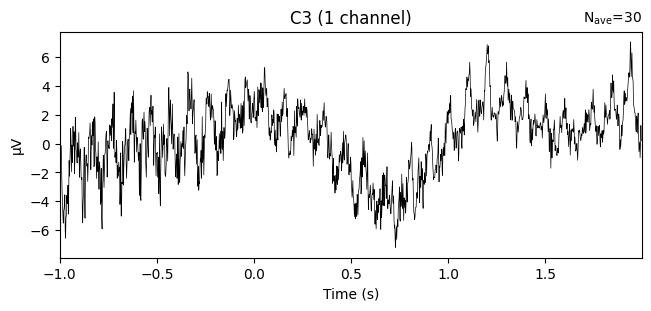

Need more than one channel to make topography for eeg. Disabling interactivity.


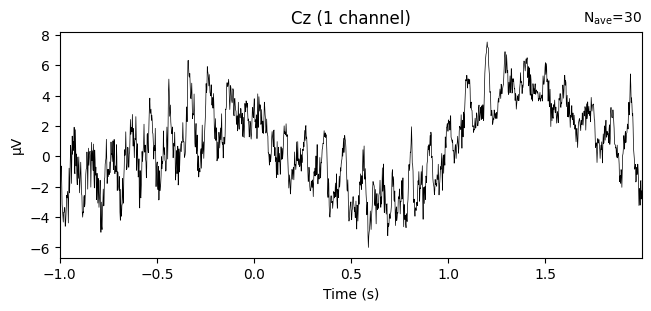

Need more than one channel to make topography for eeg. Disabling interactivity.


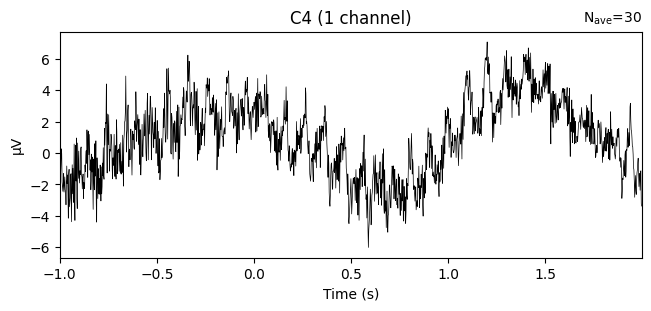

In [ ]:
#Evoked = ค่าเฉลี่ยของ Epochs ที่ตอบสนองต่อเหตุการณ์
#1. ดูลักษณะคลื่นก่อน
evoked = epochs['elbow flexion'].average()
figA = evoked.plot(picks='C3', titles='C3')
figB = evoked.plot(picks='Cz', titles='Cz')
figC = evoked.plot(picks='C4', titles='C4')


In [ ]:
#หา max amplitude
cz_idx = evoked.ch_names.index('Cz')
peak_time = evoked.times[np.argmax(np.abs(evoked.data[cz_idx]))]
print(f"⏱ Cz peak @ {peak_time:.3f} s")

⏱ Cz peak @ 1.202 s


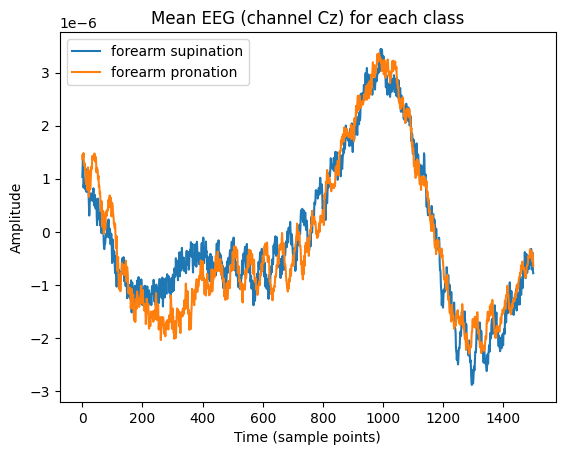

In [ ]:
#เช็คว่าค่าเฉลี่ยในแต่ละ class ต่างกันไหม (visualize signals)

mean_by_class = []
for i in range(2):  # สำหรับ 6 class
    idx = np.where(y_all == i)[0]
    mean_signal = X_all[idx].mean(axis=0)  # (channels, times)
    mean_by_class.append(mean_signal)

# ตัวอย่าง: พล็อต channel Cz (channel 7)
for i, signal in enumerate(mean_by_class):
    plt.plot(signal[7], label=list(label_map.keys())[i])
plt.legend()
plt.title("Mean EEG (channel Cz) for each class")
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
label_counts = Counter(y_all)
for label_id, count in sorted(label_counts.items()):
    label_name = [k for k, v in label_map.items() if v == label_id][0]
    print(f"{label_name:20s}: {count} samples")


forearm supination  : 1800 samples
forearm pronation   : 1800 samples
shoulder adduction  : 1800 samples
shoulder abduction  : 1800 samples
elbow extension     : 1800 samples
elbow flexion       : 1800 samples
